Lambda School Data Science

*Unit 2, Sprint 1*

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [100]:
%%capture
# If you're in Colab...
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*

In [101]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

 
# Sprint Challenge: Predicting Home Prices in Iowa 🏠

The goal of this assignment is to build a regression model that can predict the sale price of a house in Aimes, Iowa.

# Directions 

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Import training data.
- **Task 2 (`stretch goal`):** Create scatter plot.
- **Task 3:** Split data into feature matrix and target vector.
- **Task 4:** Split data into training and validation sets.
- **Task 5:** Establish baseline mean absolute error.
- **Task 6:** Build and train linear regression model.
- **Task 7:** Build and train ridge regression model.
- **Task 8:** Calculate mean absolute error for training and validation sets.
- **Task 9:** Calculate $R^2$ for validation set.
- **Task 10:** Make predictions based on test set.
- **Task 11 (`stretch goal`):** Get below 18,000 for test set MAE. 
- **Task 12 (`stretch goal`):** Plot model coefficients.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn` 

# Tasks

## I. Wrangle Data

**Task 1:** Since real estate prices fluctuate over time, it's important to index the houses in this dataset using the year in which they were sold. First, load the dataset into a DataFrame named `df` and find the column that states the year sold. Next, modify the code below so that `Yr_Sold` column is parsed as a datetime object and set as the index.

In [102]:
url_train = 'https://drive.google.com/uc?export=download&id=1tmYLQ1RwIgjI_d66PWnlXU-5D_VxtiQc'
df = pd.read_csv(url_train)
# YOUR CODE HERE

def wrangle(url_train):
  df = pd.read_csv(url_train, parse_dates=['Yr_Sold'], index_col='Yr_Sold').sort_index()

#remove constant cols
  const_col = [col for col in df.columns if df[col].nunique()==1]
  df = df.drop(columns=const_col)


#turn string columns into int binary
  df['Central_Air'] = df['Central_Air'].str.replace('Y','1').str.replace('N','0').astype(int)
  df['Paved_Drive'] = df['Paved_Drive'].str.replace('Y','1').str.replace('P','1').str.replace('N','0').astype(int)



  return df

df = wrangle(url_train)

In [103]:
df.shape

(2564, 46)

In [104]:
df

,1st_Flr_SF,Bedroom_AbvGr,Bldg_Type,Bsmt_Full_Bath,Bsmt_Half_Bath,Central_Air,Condition_1,Condition_2,Electrical,Exter_Cond,Exter_Qual,Exterior_1st,Exterior_2nd,Foundation,Full_Bath,Functional,Gr_Liv_Area,Half_Bath,Heating,Heating_QC,House_Style,Kitchen_AbvGr,Kitchen_Qual,Land_Contour,Land_Slope,Lot_Area,Lot_Config,Lot_Shape,MS_SubClass,MS_Zoning,Mas_Vnr_Type,Mo_Sold,Neighborhood,Overall_Cond,Overall_Qual,Paved_Drive,Roof_Matl,Roof_Style,SalePrice,Sale_Condition,Sale_Type,Street,TotRms_AbvGrd,Utilities,Year_Built,Year_Remod/Add
Yr_Sold,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-01,996,3,1Fam,0.0,0.0,1,Norm,Norm,SBrkr,TA,TA,HdBoard,HdBoard,PConc,2,Typ,2000,1,GasA,Ex,2Story,1,TA,Lvl,Mod,9627,Inside,Reg,60,RL,BrkFace,11,Mitchel,5,7,1,CompShg,Gable,188000,Normal,WD,Pave,9,AllPub,1993,1994
2006-01-01,1208,3,1Fam,1.0,0.0,1,Norm,Norm,SBrkr,TA,Gd,Plywood,Plywood,CBlock,1,Typ,1208,1,GasA,TA,1Story,1,TA,Lvl,Gtl,11250,Inside,IR1,20,RL,None,6,Veenker,6,6,1,CompShg,Gable,165000,Normal,WD,Pave,6,AllPub,1977,1977
2006-01-01,1494,2,TwnhsE,1.0,0.0,1,Norm,Norm,SBrkr,Gd,Gd,BrkFace,BrkFace,PConc,1,Typ,1494,1,GasA,Ex,1Story,1,Ex,Lvl,Gtl,9549,CulDSac,IR1,120,RL,None,4,Veenker,5,8,1,CompShg,Hip,270000,Normal,WD,Pave,6,AllPub,1995,1996
2006-01-01,1568,3,1Fam,0.0,0.0,1,Norm,Norm,SBrkr,TA,Gd,CemntBd,CmentBd,PConc,2,Typ,1568,0,GasA,Ex,1Story,1,Gd,Lvl,Gtl,7180,Inside,IR1,20,FV,None,9,Somerst,5,8,1,CompShg,Gable,221000,Normal,WD,Pave,6,AllPub,2001,2002
2006-01-01,854,3,1Fam,0.0,0.0,1,Norm,Norm,SBrkr,TA,Gd,Wd Sdng,Wd Sdng,PConc,2,Typ,1694,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,8314,Corner,IR1,60,FV,None,11,Somerst,5,7,1,CompShg,Hip,200000,Normal,WD,Pave,6,AllPub,1997,1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-01-01,1052,3,1Fam,0.0,0.0,1,Norm,Norm,SBrkr,TA,TA,HdBoard,HdBoard,CBlock,1,Typ,1052,1,GasA,TA,1Story,1,TA,Lvl,Gtl,11625,Inside,Reg,20,RL,BrkFace,4,Sawyer,6,5,1,CompShg,Hip,113500,Abnorml,WD,Pave,6,AllPub,1967,1967
2009-01-01,918,3,1Fam,0.0,0.0,1,Norm,Norm,SBrkr,TA,TA,HdBoard,HdBoard,CBlock,2,Typ,1683,1,GasA,Gd,2Story,1,TA,Lvl,Gtl,11184,Inside,Reg,60,RL,BrkFace,7,Sawyer,5,6,1,CompShg,Hip,172500,Normal,WD,Pave,7,AllPub,1978,1978
2009-01-01,1121,3,1Fam,1.0,0.0,1,Feedr,Norm,SBrkr,TA,TA,VinylSd,VinylSd,PConc,1,Typ,1121,0,GasA,TA,1Story,1,TA,Lvl,Gtl,8816,Corner,Reg,20,RL,None,6,Sawyer,6,5,1,CompShg,Gable,139000,Normal,WD,Pave,5,AllPub,1963,1963


In [105]:
df.isnull().sum()

1st_Flr_SF        0
Bedroom_AbvGr     0
Bldg_Type         0
Bsmt_Full_Bath    0
Bsmt_Half_Bath    0
Central_Air       0
Condition_1       0
Condition_2       0
Electrical        0
Exter_Cond        0
Exter_Qual        0
Exterior_1st      0
Exterior_2nd      0
Foundation        0
Full_Bath         0
Functional        0
Gr_Liv_Area       0
Half_Bath         0
Heating           0
Heating_QC        0
House_Style       0
Kitchen_AbvGr     0
Kitchen_Qual      0
Land_Contour      0
Land_Slope        0
Lot_Area          0
Lot_Config        0
Lot_Shape         0
MS_SubClass       0
MS_Zoning         0
Mas_Vnr_Type      0
Mo_Sold           0
Neighborhood      0
Overall_Cond      0
Overall_Qual      0
Paved_Drive       0
Roof_Matl         0
Roof_Style        0
SalePrice         0
Sale_Condition    0
Sale_Type         0
Street            0
TotRms_AbvGrd     0
Utilities         0
Year_Built        0
Year_Remod/Add    0
dtype: int64

**Task 1 Testing**

In [106]:
'''T1 Testing.'''
assert isinstance(df, pd.DataFrame), '`df` is not a DataFrame. Did you import the data?'
assert len(df) == 2564, 'DataFrame `df` has the wrong number of rows.'
assert isinstance(df.index, pd.DatetimeIndex), '`df` does not have a datetime index.'

**Task 2 (`stretch goal`):** Create a scatter plot that shows `'SalePrice'` as a function of `'Gr_Liv_Area'`. Be sure to label the axes of your plot.

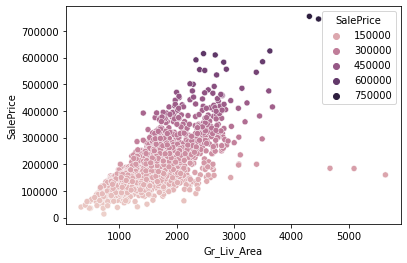

In [107]:
sns.scatterplot(x='Gr_Liv_Area', y='SalePrice',data=df,hue='SalePrice')

## II. Split Data

**Task 3:** Since you're building a model to predict the price at which a house will be sold, your target is the `'SalePrice'` column. Split the DataFrame `df` into the target vector `y` and the feature matrix `X`. 

In [108]:
'''T3: Split `df` into `X` and `y`.'''

target = 'SalePrice'
# YOUR CODE HERE

y= df[target]
X= df.drop(columns=target)

**Task 3 Testing**

In [109]:
'''T3 Tests'''
assert y.shape == (2564,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert X.shape == (2564, 45), '`X` has the wrong number of columns or rows.'
assert 'SalePrice' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Split `X` and `y` into training, validation, and test sets. Since housing prices fluctuate over time, you should use the time-based cutoff method. 

- Training: Homes sold before 2009
- Validation: Homes sold during 2009

In [110]:
'''T4: Split `X` and `y` into training, validation, and testing sets.'''

# YOUR CODE HERE


mask = (X.index < pd.to_datetime('2009'))

X_train, y_train = X[mask], y[mask]
X_val, y_val = X[~mask], y[~mask]

**Task 4 Testing**

In [111]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 1920, 'Your training set has the wrong number of rows.'
assert len(X_val) == len(y_val) == 644, 'Your validation set has the wrong number of rows.'

## III. Set Baseline

**Task 5:** Before you can create a model to predict sale price, you need to establish a baseline. First, calculate the mean housing price for your training set. Next, calculate the *mean absolute error* for a model that always predicts that mean. Be sure to assign the mean absolute error to a variable named `baseline_mae`.

In [137]:
y_train.mean()

181515.98645833333

In [112]:
'''T5: Calculate baseline mean absolute error.'''
from sklearn.metrics import mean_absolute_error

# YOUR CODE HERE

baseline_mae = y_train.value_counts(normalize=True).max()


print('Baseline MAE:', baseline_mae)

Baseline MAE: 0.013541666666666667


**Task 5 Testing**

In [113]:
'''T5 Tests'''
assert isinstance(baseline_mae, float), '`baseline_mae` is not a `float`. Have you assigned a value to this variable name?'

## IV. Build Models

**Task 6:** Build and train a linear regression model named `model_lr` that predicts home sale price. Your model should have the following components:

- A `OneHotEncoder` for categorical features.
- A `StandardScaler` so that you can compare your model coefficients after training.
- A `pipeline` that combines transformers and predictor.

**Tip:** For your `OneHotEncoder`, `use_cat_names` should be set to `True`.

In [114]:
'''T6: Build and train LinearRegression model.'''
# YOUR CODE HERE
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression()
)



model_lr.fit(X_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**Task 6 Testing**

In [115]:
'''T6 Tests'''
from sklearn.pipeline import Pipeline
assert isinstance(model_lr, Pipeline), '`model_lr` is not a pipeline.'
assert len(model_lr.named_steps) > 1, 'Your `model_lr` pipeline is missing components.'

**Task 7:** Build and train a ridge regression model named `model_r` that predicts home sales price. Your model should include the following components:

- A `OneHotEncoder` for categorical features.
- A `StandardScaler` so that you can compare your model coefficients after training.
- A `pipeline` that combines transformers and predictor.

**Tip:** If you combine a `StandardScaler` transformer with a `Ridge` predictor, you should set the `normalize` argument for the latter to `False`.

In [116]:
'''T7. Build and train Ridge model.'''


# YOUR CODE HERE

model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    Ridge(alpha=5.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001)

)

model_r.fit(X_train, y_train);

**Task 7 Testing**

In [117]:
assert isinstance(model_r, Pipeline), '`model_r` is not a pipeline.'
assert len(model_r.named_steps) > 1, 'Your `model_r` pipeline is missing components.'

## V. Check Metrics

**Task 8:** Compare your models by calculating their mean absolute error for the training and validation sets. You should assign these to the variables `model_lr_training_mae`, `model_lr_validation_mae`, `model_r_training_mae`, and `model_r_validation_mae`, respectively. The validation MAE for both your models should be lower than your `baseline_mae`.

In [118]:
'''T8: Compare model metrics, MAE.'''
# YOUR CODE HERE
mae = mean_absolute_error

model_lr_training_mae = mae(y_train,model_lr.predict(X_train))
model_lr_validation_mae = mae(y_val,model_lr.predict(X_val))

model_r_training_mae = mae(y_train,model_r.predict(X_train))
model_r_validation_mae = mae(y_val,model_r.predict(X_val))

print('Linear Regression Model')
print('Training MAE:', model_lr_training_mae)
print('Validation MAE:', model_lr_validation_mae)
print()
print('Ridge Regression Model')
print('Training MAE:', model_r_training_mae)
print('Validation MAE:', model_r_validation_mae)


#Ridge Regression Model - prior to hypertuning
#Training MAE: 16120.536291768944
#Validation MAE: 17987.248622969608

Linear Regression Model
Training MAE: 561.190625
Validation MAE: 30977.209627329194

Ridge Regression Model
Training MAE: 16101.162727209103
Validation MAE: 17940.797096928098


**Task 8 Testing**

In [119]:
'''T8 Tests'''
assert isinstance(model_lr_training_mae, float), '`model_lr_training_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_lr_validation_mae, float), '`model_lr_validation_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_training_mae, float), '`model_r_training_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_validation_mae, float), '`model_r_validation_mae` is not a float. Did you assign a value to this variable?'

**Task 9:** Compare your two models by calculating their $R^2$ score for the **validation data**.

In [120]:
'''T9: Compare model metrics, R^2.'''
# YOUR CODE HERE

y_lr_pred = model_lr.predict(X_val)
y_r_pred = model_r.predict(X_val)

model_lr_r2_score = r2_score(y_val, y_lr_pred)
model_r_r2_score = r2_score(y_val, y_r_pred)

print('Linear Regression R^2:', model_lr_r2_score)
print('Ridge Regression R^2:', model_r_r2_score)

Linear Regression R^2: 0.6321921572748815
Ridge Regression R^2: 0.88916203295111


**Task 9 Testing**

In [121]:
'''T9 Tests'''
assert isinstance(model_lr_r2_score, float), '`model_lr_r2_score` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_r2_score, float), '`model_r_r2_score` is not a float. Did you assign a value to this variable?'
assert model_lr_r2_score <= 1, 'The maximum value for an R^2 score is 1.'
assert model_r_r2_score <= 1, 'The maximum value for an R^2 score is 1.'

**Task 10:** Based on the metrics above, choose the best of your two models and generate an array of predictions `y_pred` using the test set below.

**Note:** Make sure that you import and clean the test set *exactly the same way* you did with the training set at the start of this notebook.

In [122]:
url_test = 'https://drive.google.com/uc?export=download&id=1y9u8cOWprTjruw8E-ct1c7YaEytToqd_'
X_test = pd.read_csv(url_test)


In [123]:
X_test.shape

(340, 46)

In [124]:
X_test

,Yr_Sold,1st_Flr_SF,Bedroom_AbvGr,Bldg_Type,Bsmt_Full_Bath,Bsmt_Half_Bath,Central_Air,Condition_1,Condition_2,Electrical,Exter_Cond,Exter_Qual,Exterior_1st,Exterior_2nd,Foundation,Full_Bath,Functional,Gr_Liv_Area,Half_Bath,Heating,Heating_QC,House_Style,Kitchen_AbvGr,Kitchen_Qual,Land_Contour,Land_Slope,Lot_Area,Lot_Config,Lot_Shape,MS_SubClass,MS_Zoning,Mas_Vnr_Type,Mo_Sold,Neighborhood,Overall_Cond,Overall_Qual,Paved_Drive,Roof_Matl,Roof_Style,Sale_Condition,Sale_Type,Street,TotRms_AbvGrd,Utilities,Year_Built,Year_Remod/Add
0,2010-01-01,1656,3,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,BrkFace,Plywood,CBlock,1,Typ,1656,0,GasA,Fa,1Story,1,TA,Lvl,Gtl,31770,Corner,IR1,20,RL,Stone,5,NAmes,5,6,P,CompShg,Hip,Normal,WD,Pave,7,AllPub,1960,1960
1,2010-01-01,896,2,1Fam,0.0,0.0,Y,Feedr,Norm,SBrkr,TA,TA,VinylSd,VinylSd,CBlock,1,Typ,896,0,GasA,TA,1Story,1,TA,Lvl,Gtl,11622,Inside,Reg,20,RH,None,6,NAmes,6,5,Y,CompShg,Gable,Normal,WD,Pave,5,AllPub,1961,1961
2,2010-01-01,1329,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,Wd Sdng,Wd Sdng,CBlock,1,Typ,1329,1,GasA,TA,1Story,1,Gd,Lvl,Gtl,14267,Corner,IR1,20,RL,BrkFace,6,NAmes,6,6,Y,CompShg,Hip,Normal,WD,Pave,6,AllPub,1958,1958
3,2010-01-01,2110,3,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,Gd,BrkFace,BrkFace,CBlock,2,Typ,2110,1,GasA,Ex,1Story,1,Ex,Lvl,Gtl,11160,Corner,Reg,20,RL,None,4,NAmes,5,7,Y,CompShg,Hip,Normal,WD,Pave,8,AllPub,1968,1968
4,2010-01-01,928,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,VinylSd,VinylSd,PConc,2,Typ,1629,1,GasA,Gd,2Story,1,TA,Lvl,Gtl,13830,Inside,IR1,60,RL,None,3,Gilbert,5,5,Y,CompShg,Gable,Normal,WD,Pave,6,AllPub,1997,1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,2010-01-01,1216,4,Duplex,0.0,0.0,Y,Norm,Norm,SBrkr,Po,TA,HdBoard,HdBoard,PConc,4,Typ,2432,2,GasA,Gd,2Story,2,TA,Lvl,Gtl,7700,Inside,Reg,90,RL,None,2,Mitchel,2,5,Y,CompShg,Gable,Normal,WD,Pave,10,AllPub,1985,1986
336,2010-01-01,624,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,HdBoard,HdBoard,PConc,1,Typ,1274,1,GasA,Gd,2Story,1,TA,Lvl,Gtl,10475,Inside,Reg,60,RL,None,3,Mitchel,5,5,Y,CompShg,Gable,Normal,WD,Pave,6,AllPub,1991,1991
337,2010-01-01,864,5,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,HdBoard,HdBoard,CBlock,2,Typ,1479,0,GasA,TA,1.5Fin,1,TA,Lvl,Mod,10544,Inside,IR1,50,RL,None,4,Mitchel,5,5,Y,CompShg,Gable,Normal,WD,Pave,8,AllPub,1969,1969
338,2010-01-01,1803,3,1Fam,1.0,1.0,Y,Norm,Norm,SBrkr,Gd,Gd,VinylSd,VinylSd,PConc,2,Typ,1803,1,GasA,Ex,1Story,1,Gd,Lvl,Mod,9892,Inside,Reg,20,RL,None,2,Mitchel,5,8,Y,CompShg,Hip,Normal,WD,Pave,6,AllPub,1994,1995


In [125]:
# YOUR CODE HERE

def wrangle2(url_test):
  X_test = pd.read_csv(url_test, parse_dates=['Yr_Sold'], index_col='Yr_Sold').sort_index()


#turn string columns into int binary
  X_test['Central_Air'] = X_test['Central_Air'].astype(str).str.replace('Y','1').str.replace('N','0').astype(int)
  X_test['Paved_Drive'] = X_test['Paved_Drive'].astype(str).str.replace('Y','1').str.replace('P','1').str.replace('N','0').astype(int)

  return X_test

X_test = wrangle2(url_test)


In [126]:
X_test.nunique() ==1

1st_Flr_SF        False
Bedroom_AbvGr     False
Bldg_Type         False
Bsmt_Full_Bath    False
Bsmt_Half_Bath    False
Central_Air       False
Condition_1       False
Condition_2       False
Electrical        False
Exter_Cond        False
Exter_Qual        False
Exterior_1st      False
Exterior_2nd      False
Foundation        False
Full_Bath         False
Functional        False
Gr_Liv_Area       False
Half_Bath         False
Heating           False
Heating_QC        False
House_Style       False
Kitchen_AbvGr     False
Kitchen_Qual      False
Land_Contour      False
Land_Slope        False
Lot_Area          False
Lot_Config        False
Lot_Shape         False
MS_SubClass       False
MS_Zoning         False
Mas_Vnr_Type      False
Mo_Sold           False
Neighborhood      False
Overall_Cond      False
Overall_Qual      False
Paved_Drive       False
Roof_Matl         False
Roof_Style        False
Sale_Condition    False
Sale_Type         False
Street            False
TotRms_AbvGrd   

In [127]:
X_test.shape # 

(340, 45)

In [128]:
#X_test = X_test.drop(columns='SalePrice')

In [129]:
y_pred = model_r.predict(X_test)

print('My predictions:', y_pred)

My predictions: [219598.54556294 104308.71514115 159650.36555731 293097.35283963
 166785.89258258 181054.21120359 243682.97563058 229757.55616482
 265304.4059382  192411.04785604 167221.59086359 183758.71654234
 158293.82566772 191549.97633284 245179.25145243 495869.79793362
 195292.51351111 357403.81381031  97621.49008623 226272.44099767
 206606.26611979 178966.23226259 233007.11717294 170692.50674645
 158558.63263461 139029.30635856 112691.63598746  73238.67292729
 172758.92598914  90889.03647352  87211.22145625 117489.71035226
 140304.801349   129315.68871128 114601.19800358 125619.42202787
 376181.32948435 292579.67641596 392170.19046835 273476.4876636
 261921.79474071 341065.04331123 320924.11562518 251609.9903007
 418135.36997357 235271.5677433  456298.75383477 315534.93668787
 341626.16887734 220503.42108221 180296.15051569 182393.03911062
 168135.66205482 185258.4149953  198875.59781874 196588.8759248
 180137.86375715 226369.27746018 326403.75405468 343413.24143894
 290346.9799

**Task 10 Testing:** There is a hidden test in the cell below. When you submit your notebook to Canvas, your test MAE will be calculated. In order to get the point for this task, your test MAE must be below 58,000.

**Tip:** Use your validation MAE to estimate what your test MAE will be.

In [130]:
len(y_pred)

340

In [131]:
import numpy as np
assert isinstance(y_pred, np.ndarray), '`y_pred` should be type `ndarray`.'
assert y_pred.shape == (340,), '`y_pred` should be a 1-dimentional array with 340 predictions.'
# Your test MAE will be printed out below when you submit your assignment.

**Task 11 (`stretch goal`):** There's no code to write for this task. Below is another testing cell that will calculate the MAE for your test set. In order to get the point for this task, your test MAE must be below 18,000.

**Tip:** Are there any **hyperparameters** in your model that you could adjust to improve performance? 

In [132]:
assert isinstance(y_pred, np.ndarray), '`y_pred` should be type `ndarray`.'
assert y_pred.shape == (340,), '`y_pred` should be a 1-dimentional array with 340 predictions.'
# Your test MAE will be printed out below when you submit your assignment.

## VI. Explain Model

**Task 12 (`stretch goal`):** Create a horizontal barchart for your best performing model that shows the ten most important features for the model's predictions. Don't forget to label your axes!

In [99]:
# YOUR CODE HERE

features = model_r.named_steps['onehotencoder'].get_feature_names()
gini = model_r.named_steps['ridgeregression'].feature_importances_ 
pd.Series(data=gini, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance')
#AttributeError: 'Ridge' object has no attribute 'feature_importances_'

AttributeError: ignored